# ViT Vision Transformer Paper implementation

## Getting setup

We are going to implement the vision transformer paper for shoe branch classification. 

The model should be able to classify if the input image is a **Adidas**, **Converse** or **Nike** shoe.

### Import Necessary dependencies

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import sys 
sys.path.append("/home/home/dev/ViT-vision-transformer")

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from vit.utils.helper import *
from vit.dataloader.dataloader import *
from vit.train_test.train_test import *

The helper function scripts are inside the `vit/utils` directory. 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load dataset


In [ ]:
# !unzip /content/dataset.zip

In [1]:
import os
image_path = os.path.join("dataset")
image_path

'dataset'

we have defined the dataset path, now lets do the same for train and test set.

In [9]:
# Setup directory paths to train and test images
train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path,"test")

## Create Datasets and DataLoaders


We need to convert our dataset into pytorch friendly object which can be done using `Dataloader`. 

Before that we create define some Transform parameters for our images.

As per the Table 3 of the ViT paper, the training resolution is mentioned as being 224 (height=224, width=224). So, we do the necessary transformation of our images.

### Prepare transforms for images

In [4]:
# From Table 3 in the ViT paper
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### Convert images into `DataLoader`'s

As per ViT paper, the batch size is 4096, which will require a high end hardware. So we are going to stick to a 32 batch size.

In [11]:
BATCH_SIZE = 32 

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78206e40e950>,
 ['adidas', 'converse', 'nike'])

### Sample Image


In [12]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

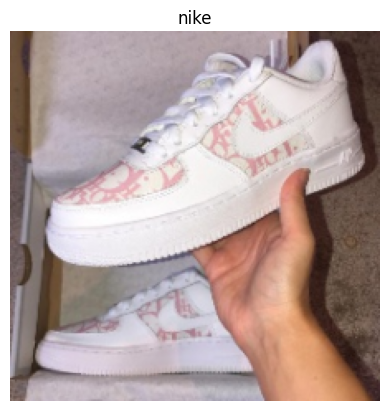

In [13]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions for matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Patching Images

In [14]:
height = 224 # H 
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2) # as per the ViT Paper
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [15]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Create patches using Conv2D

Keeping the **kernel** size as `patch_size x patch` or in this case `(16 x 16)` and the **stride** as `patch_size` long with `channels=3` for **color channels**. Finally, the `out channel=768` which is the **embedding dimension** as per the Vit Paper.

In [20]:
from torch import nn

# Set the patch size
patch_size=16

conv2d = nn.Conv2d(in_channels=3, # color channels
                   out_channels=768, # From Table 1 ~ embedding dimension
                   kernel_size=patch_size, # patch_size x patch_size
                   stride=patch_size,
                   padding=0)

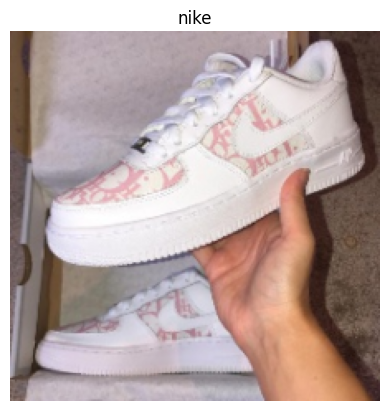

In [21]:
# Sample image
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);

In [22]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # Adding single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [117, 330, 585, 139, 93]


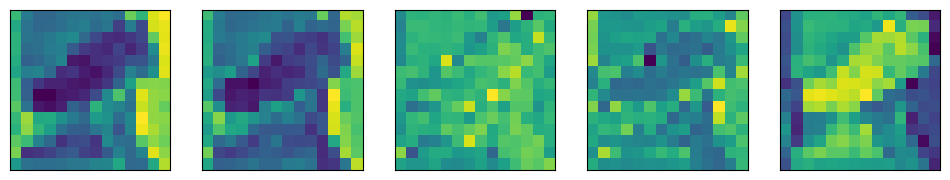

In [23]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [24]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 5.6880e-02, -2.2892e-02, -3.7761e-02, -4.0701e-02, -4.1322e-02,
           -4.5770e-02, -2.7985e-02, -4.1446e-02, -1.8884e-02, -1.8179e-02,
           -2.2501e-02,  2.0557e-01, -3.3378e-02,  1.6732e-02],
          [ 2.5519e-02, -2.5529e-02, -4.8700e-02, -3.3757e-02, -4.2646e-02,
           -4.4215e-02, -2.2607e-02, -5.6534e-02,  4.3805e-02,  3.0085e-02,
            3.7897e-02, -2.0987e-02, -4.3335e-02,  3.5692e-02],
          [ 4.1178e-02, -3.0548e-02, -4.7624e-02, -5.1331e-02, -2.9393e-02,
           -1.9839e-02, -1.0876e-02, -6.2922e-02, -9.7568e-02, -2.2782e-02,
           -3.1409e-02, -5.7479e-02, -9.4720e-03,  2.8250e-02],
          [ 2.4635e-02, -2.7291e-02, -4.7627e-02, -4.0751e-02, -2.8162e-02,
           -2.2336e-03, -2.2887e-02, -1.3429e-01, -4.5169e-02, -6.1878e-02,
           -6.0031e-02, -4.0807e-02, -4.3169e-03,  8.9050e-03],
          [ 3.1468e-02, -6.1872e-02, -5.5242e-02, -4.8590e-02,  1.3401e-02,
           -9.2966e-02, -7.8147e-02, -5.5695e-02, -5.3474e-0

The `grad_fn` output of the `single_feature_map` and 

the `requires_grad=True` attribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training.

### Flattening the patch embedding

In [25]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [26]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


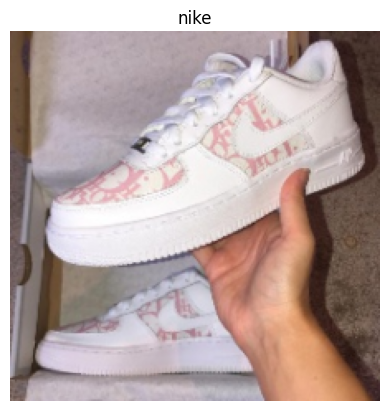

In [27]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

`torch.Tensor.permute()` used for rearranging image tensors to plot them with matplotlib.

In [28]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


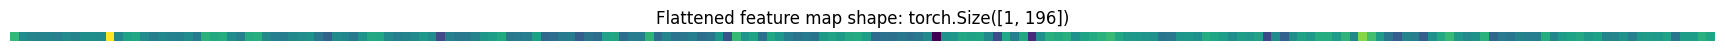

In [29]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # (batch_size, number_of_patches, embedding_dimension)

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [30]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 5.6880e-02, -2.2892e-02, -3.7761e-02, -4.0701e-02, -4.1322e-02,
          -4.5770e-02, -2.7985e-02, -4.1446e-02, -1.8884e-02, -1.8179e-02,
          -2.2501e-02,  2.0557e-01, -3.3378e-02,  1.6732e-02,  2.5519e-02,
          -2.5529e-02, -4.8700e-02, -3.3757e-02, -4.2646e-02, -4.4215e-02,
          -2.2607e-02, -5.6534e-02,  4.3805e-02,  3.0085e-02,  3.7897e-02,
          -2.0987e-02, -4.3335e-02,  3.5692e-02,  4.1178e-02, -3.0548e-02,
          -4.7624e-02, -5.1331e-02, -2.9393e-02, -1.9839e-02, -1.0876e-02,
          -6.2922e-02, -9.7568e-02, -2.2782e-02, -3.1409e-02, -5.7479e-02,
          -9.4720e-03,  2.8250e-02,  2.4635e-02, -2.7291e-02, -4.7627e-02,
          -4.0751e-02, -2.8162e-02, -2.2336e-03, -2.2887e-02, -1.3429e-01,
          -4.5169e-02, -6.1878e-02, -6.0031e-02, -4.0807e-02, -4.3169e-03,
           8.9050e-03,  3.1468e-02, -6.1872e-02, -5.5242e-02, -4.8590e-02,
           1.3401e-02, -9.2966e-02, -7.8147e-02, -5.5695e-02, -5.3474e-02,
          -1.0445e-01, -6

## PatchEmbedding Module

In [5]:
from vit.blocks.patch_embedding import PatchEmbedding

In [32]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [33]:
from torchinfo import summary
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Class Token Embedding

As per the ViT paper, Similar to BERT's `[ class ]` token, a learnable embedding is provided to the sequence of embedded patches, whose state at the output of the Transformer encoder serves as the image representation.

In [34]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.4607,  0.1215, -0.0736,  ...,  0.1956, -0.1760,  0.2424],
         [-0.6967,  0.1953, -0.1816,  ...,  0.4758, -0.3038,  0.2218],
         [-0.7579,  0.1883, -0.2043,  ...,  0.5538, -0.3217,  0.2518],
         ...,
         [-0.7794,  0.1075, -0.1651,  ...,  0.5157, -0.3763,  0.3066],
         [-0.5994,  0.0151, -0.1666,  ...,  0.3850, -0.2841,  0.3214],
         [-0.2106,  0.0306, -0.1287,  ...,  0.0710, -0.1406,  0.2788]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [35]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Class token of the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


`torch.ones` is used for demonstration. In production, `torch.rand` can be used instead.

In [36]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4607,  0.1215, -0.0736,  ...,  0.1956, -0.1760,  0.2424],
         [-0.6967,  0.1953, -0.1816,  ...,  0.4758, -0.3038,  0.2218],
         ...,
         [-0.7794,  0.1075, -0.1651,  ...,  0.5157, -0.3763,  0.3066],
         [-0.5994,  0.0151, -0.1666,  ...,  0.3850, -0.2841,  0.3214],
         [-0.2106,  0.0306, -0.1287,  ...,  0.0710, -0.1406,  0.2788]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Positional embedding

Position embeddings are added to the patch embeddings to retain positional information.

They want the architecture to know what "order" the patches come in. As in, patch two comes after patch one and patch three comes after patch two and on and on.

This positional information can be important when considering what's in an image (without positional information an a flattened sequence could be seen as having no order and thus no patch relates to any other patch).

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9145,  0.2454, -0.2292,  ...,  0.6768, -0.4515,  0.3496],
          [-0.7427,  0.1955, -0.3570,  ...,  0.5823, -0.3458,  0.3261],
          ...,
          [-1.0072,  0.2795, -0.2804,  ...,  0.7624, -0.4584,  0.3581],
          [-0.9839,  0.1652, -0.1576,  ...,  0.7489, -0.5478,  0.3486],
          [-0.9260,  0.1383, -0.1157,  ...,  0.5847, -0.4717,  0.3112]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [37]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [38]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5393, 1.1215, 0.9264,  ..., 1.1956, 0.8240, 1.2424],
         [0.3033, 1.1953, 0.8184,  ..., 1.4758, 0.6962, 1.2218],
         ...,
         [0.2206, 1.1075, 0.8349,  ..., 1.5157, 0.6237, 1.3066],
         [0.4006, 1.0151, 0.8334,  ..., 1.3850, 0.7159, 1.3214],
         [0.7894, 1.0306, 0.8713,  ..., 1.0710, 0.8594, 1.2788]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Let's look at the Patching in Action!

In [39]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Multi-Head Attention (MSA)

### LayerNorm (LN) 

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

### Multi-Head Self Attention layer

Since our input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

In [6]:
from vit.blocks.multiheadselfattn_block import MultiheadSelfAttentionBlock

In [41]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## Multilayer Perceptron (MLP)

### MLP layer(s)

As per the paper, The MLP contains two layers with a GELU non-linearity, Where "two layers" refers to linear layers and "GELU non-linearity" is the GELU  (Gaussian Error Linear Units) non-linear activation function.

In [ ]:
from vit.blocks.multilayerperceptron_block import MultiLayerPerceptronBlock

In [43]:
# Create an instance of MLPBlock
mlp_block = MultiLayerPerceptronBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## Transformer Encoder Block

An encoder generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation). 

As per the paper, the Transformer Encoder will encode the patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks.

The transformer block will have residual connection, that will prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

In [7]:
from vit.blocks.transformer_encoder_block import TransformerEncoderBlock

In [45]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### PyTorch's Transformer layers

In [46]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, 
                                                             nhead=12, 
                                                             dim_feedforward=3072,
                                                             dropout=0.1, 
                                                             activation="gelu", 
                                                             batch_first=True, 
                                                             norm_first=True) 
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [47]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## ViT Model

In [48]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # From Table 3 in ViT paper
                 in_channels:int=3, # Channels
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # From Table 1 for ViT-Base
                 embedding_dim:int=768, # From Table 1 for ViT-Base
                 mlp_size:int=3072, # From Table 1 for ViT-Base
                 num_heads:int=12, # From Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # ImageNet default
        super().__init__() 

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [50]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [51]:
from torchinfo import summary

summary(model=vit,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## Training ViT model

### Optimizer

In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # From Table 3
                             betas=(0.9, 0.999), # Section 4
                             weight_decay=0.3) # From section 4

### Loss function

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [52]:
set_seeds()

# from train_test module
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1899 | train_acc: 0.3284 | test_loss: 1.1217 | test_acc: 0.2969
Epoch: 2 | train_loss: 1.1399 | train_acc: 0.3160 | test_loss: 1.0992 | test_acc: 0.2969
Epoch: 3 | train_loss: 1.1244 | train_acc: 0.3354 | test_loss: 1.1394 | test_acc: 0.2969
Epoch: 4 | train_loss: 1.1200 | train_acc: 0.3261 | test_loss: 1.1087 | test_acc: 0.4062
Epoch: 5 | train_loss: 1.1407 | train_acc: 0.3175 | test_loss: 1.1647 | test_acc: 0.2969
Epoch: 6 | train_loss: 1.1260 | train_acc: 0.3249 | test_loss: 1.1081 | test_acc: 0.4062
Epoch: 7 | train_loss: 1.1280 | train_acc: 0.3426 | test_loss: 1.1000 | test_acc: 0.2969
Epoch: 8 | train_loss: 1.1208 | train_acc: 0.3290 | test_loss: 1.0969 | test_acc: 0.4062
Epoch: 9 | train_loss: 1.1178 | train_acc: 0.3193 | test_loss: 1.1034 | test_acc: 0.2969
Epoch: 10 | train_loss: 1.1104 | train_acc: 0.3405 | test_loss: 1.1005 | test_acc: 0.2969


### loss curves of our ViT model

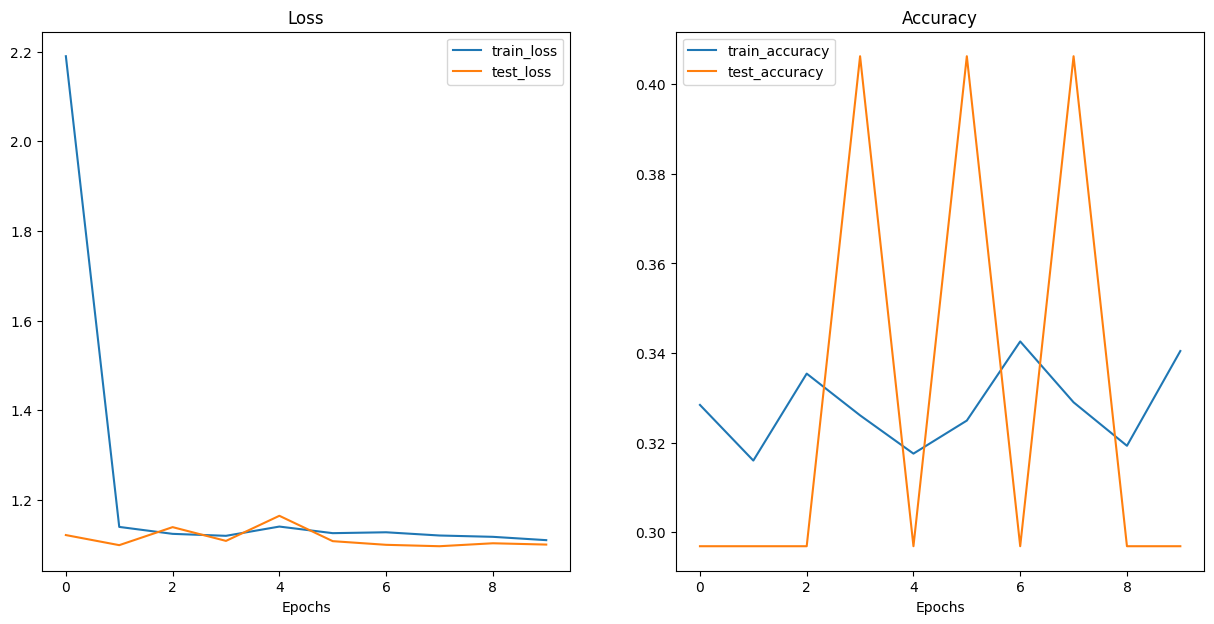

In [53]:
# loss curves from utils
from vit.utils.plot import plot_loss_curves
plot_loss_curves(results)

The results can be improved with more data and hardware support but at the current stage, it would be a better choice to use some pretrained weights.

## Using Pretrained ViT model weights

In [54]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [60]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# freeze base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 61.2MB/s]


In [ ]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [9]:
image_path = os.path.join("dataset")
image_path

'dataset'

In [11]:
train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

In [62]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [63]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) 

### Train the pretrained model on our shoe dataset

In [64]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9659 | train_acc: 0.5454 | test_loss: 0.8206 | test_acc: 0.6849
Epoch: 2 | train_loss: 0.7484 | train_acc: 0.7184 | test_loss: 0.7247 | test_acc: 0.7214
Epoch: 3 | train_loss: 0.6332 | train_acc: 0.8009 | test_loss: 0.6581 | test_acc: 0.7569
Epoch: 4 | train_loss: 0.5663 | train_acc: 0.8321 | test_loss: 0.6124 | test_acc: 0.7587
Epoch: 5 | train_loss: 0.5008 | train_acc: 0.8688 | test_loss: 0.5842 | test_acc: 0.7648
Epoch: 6 | train_loss: 0.4546 | train_acc: 0.8769 | test_loss: 0.5582 | test_acc: 0.7726
Epoch: 7 | train_loss: 0.4117 | train_acc: 0.8967 | test_loss: 0.5462 | test_acc: 0.7726
Epoch: 8 | train_loss: 0.3861 | train_acc: 0.9090 | test_loss: 0.5288 | test_acc: 0.7665
Epoch: 9 | train_loss: 0.3688 | train_acc: 0.9109 | test_loss: 0.5137 | test_acc: 0.7804
Epoch: 10 | train_loss: 0.3378 | train_acc: 0.9307 | test_loss: 0.5094 | test_acc: 0.7821


### ViT model loss curves

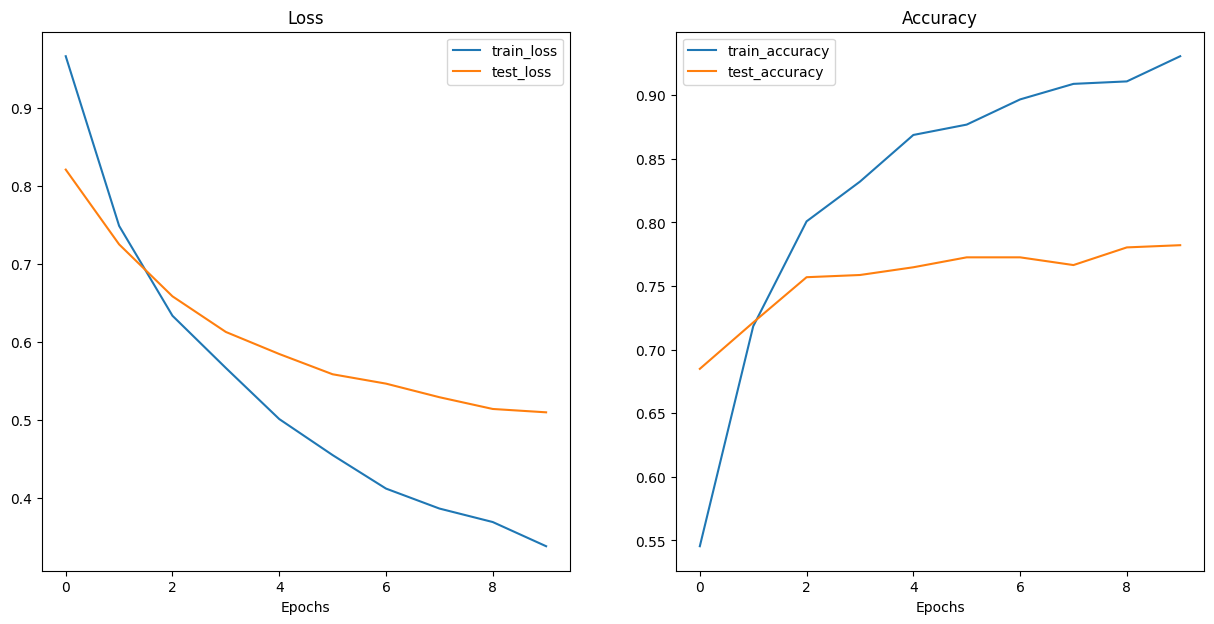

In [65]:
# Plot the loss curves
plot_loss_curves(pretrained_vit_results)

There definiely an improvement.

### Save the model

In [66]:
# Save the model
from vit.utils.helper import save_model
save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_shoe_classifier.pth")

[INFO] Saving model to: models/pretrained_vit_shoe_classifier.pth


## Prediction

In [ ]:
from vit.utils.plot import pred_and_plot_image
custom_image_path = os.path.join(image_path,"sampleimagejpg")
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)